# Designing Communication Topologies via Graph Neural Networks
Fengjun Yang, Anish Battacharya, Nikolai Matni (2021)

In [2]:
%load_ext autoreload
%autoreload 2

# Useful Libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import networkx as nx

# Source Files
import grnn, exp_utils, controller
import env.dlqr

# Other bookkeeping
%matplotlib inline
np.set_printoptions(precision=3)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = 'cpu'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## How to train and run the GRNN model

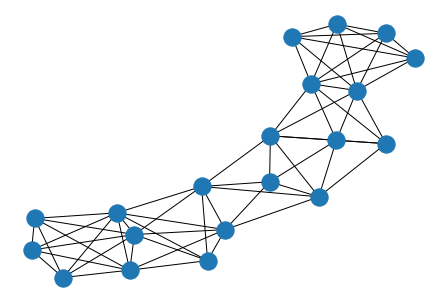

In [4]:
# Create an environment
N = 20
T = 50
p, q = 1, 1
degree = 5 + 1     # All nodes are assumed to have a self-loop, hence the +1

# Generate environment (here an LQR environment)
dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
nx.draw_kamada_kawai(G)

In [5]:
# Define training loss
def criterion(x_traj, u_traj, env, model):
    return env.cost(x_traj, u_traj)

In [6]:
# Create model
hidden_state_dim = 5
S = dlqrenv.S.clone()
model = grnn.GRNN(S, N, T, p, q, hidden_state_dim, S_trainable=True).to(device)

In [7]:
# Train model
model = exp_utils.train_model(model, dlqrenv, criterion, num_epoch=100, verbose=True)

Epoch: 1 	 Loss: 233.02310696283058
Epoch: 11 	 Loss: 49.331795936798855
Epoch: 21 	 Loss: 40.77295856883251
Epoch: 31 	 Loss: 36.19483311070639
Epoch: 41 	 Loss: 38.94116815022909
Epoch: 51 	 Loss: 36.02715120145733
Epoch: 61 	 Loss: 37.882236134822726
Epoch: 71 	 Loss: 40.73995763615877
Epoch: 81 	 Loss: 32.85589494891262
Epoch: 91 	 Loss: 32.846910206017625


In [8]:
# Define controllers we want to compare to
lqrctrl = dlqrenv.get_optimal_controller()
grnnctrl = model.get_controller()
zeroctrl = controller.ZeroController(N, q)
randctrl = controller.RandomController(N, q)
controllers = [lqrctrl, grnnctrl, zeroctrl, randctrl]
names = ['Global Optimal', 'GRNN', 'Autonomous', 'Random']

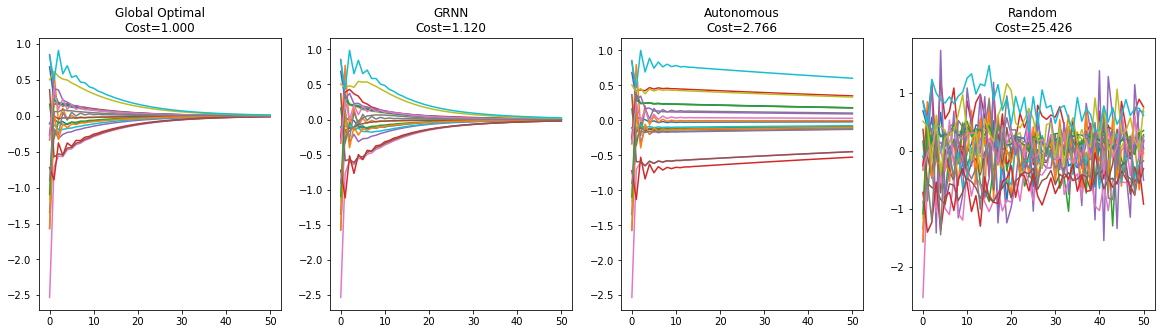

In [9]:
# Simulate each controller forward from the same initial condition
x0 = dlqrenv.random_x0()
xs, us, costs = exp_utils.sim_controllers(dlqrenv, x0, controllers, T, x0.device)
exp_utils.plot_controllers(xs, names, costs, 0)

## Experiment 1: GRNN on LQR Systems with Given Communication Topology

In [24]:
# Parameters for the model and the training process
N, T, p, q = 20, 50, 1, 1

model_params = {
    'N':N,
    'T':T,
    'p':p,
    'q':q,
    'h':5,
    'S_trainable':True
}

training_params = {
    'criterion': criterion,
    'use_given_support': True,
    'T': T,
    'device': device,
    'num_epoch': 100,
    'batch_size': 20,
    'ensemble_size': 3,
    'val_size': 50,
}

# Additional controllers to compare to
zeroctrl = controller.ZeroController(N, q)
randctrl = controller.RandomController(N, q)
additional_controllers = [zeroctrl, randctrl]
num_controllers = len(additional_controllers) + 2

# Training loss
def criterion(x_traj, u_traj, env, model):
    return env.cost(x_traj, u_traj)

# Experiment parameters
num_topologies = 50
num_x0s = 100

verbose = True

In [26]:
# Evaluate the performance of GRNN
total_rel_costs = np.zeros(num_controllers)
relative_ind = 0

rel_costs_table = np.zeros((num_topologies, num_controllers))
envs = []

for counter in range(num_topologies):
    # Generate an environment
    dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
    
    model = exp_utils.generate_model(model_params, dlqrenv, **training_params)
    
    # Test the performance of GRNN on this env
    rel_costs = exp_utils.estimate_grnn_cost(
        dlqrenv, model, T, additional_controllers, num_x0s=num_x0s)
    total_rel_costs += rel_costs
    
    rel_costs_table[counter] = rel_costs
    envs.append(dlqrenv)

    # Print progress
    if verbose:
        print('Iteration {}:\t{}\t{}'.format(counter+1, rel_costs, total_rel_costs / (counter+1)))

# Print result
print(total_rel_costs / num_topologies)

[1.145667624389314, 1.1407622949281528, 1.2752097751416576] 1
Iteration 1:	[ 1.     1.141  2.036 49.694]	[ 1.     1.141  2.036 49.694]


KeyboardInterrupt: 

## Experiment 2: Generate Communication Topology w/ GRNN

In [359]:
# Parameters for the model
model_params = {
    'N':20,
    'T':50,
    'p':1,
    'q':1,
    'h':5,
    'S_trainable':True
}
use_given_support = False

# Additional controllers to compare to
zeroctrl = controller.ZeroController(N, q)
randctrl = controller.RandomController(N, q)
additional_controllers = [zeroctrl, randctrl]
num_controllers = len(additional_controllers) + 2

# Training loss
beta = 1
def criterion(x_traj, u_traj, env, model):
    global beta
    return env.cost(x_traj, u_traj) + beta * torch.sum(torch.abs(model.S_()))

# Experiment parameters
num_epoch = 100
batch_size = 20
verbose = True
threshold = 1e-3
betas = np.logspace(-5, 2, 10)

In [360]:
S_weights = np.zeros((len(betas), N*N))
costs = np.zeros(len(betas))

dlqrenv, G = env.dlqr.generate_lq_env(N, degree, device)
for i, beta in enumerate(betas):
    grnn_S = exp_utils.grnn_topology(
        dlqrenv, criterion, model_params, threshold, device, num_epoch=num_epoch)
    S_weights[i] = grnn_S.cpu().numpy().flatten()
    new_S = grnn_S.clone()
    new_S[new_S < threshold] = 0
    model = grnn.GRNN(S, **model_params).to(device)
    model = exp_utils.train_model(model, dlqrenv, criterion, num_epoch=num_epoch)
    costs[i] = exp_utils.estimate_grnn_cost(dlqrenv, model, T)[1]

Text(0, 0.5, 'LQR Cost')

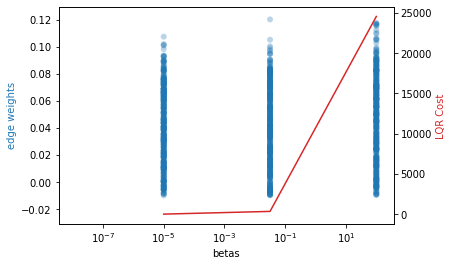

In [379]:
fig = plt.figure()
ax = plt.gca()
ax.set_xscale('log')
for i, beta in enumerate(betas):
    ax.scatter(np.ones(N*N)*beta, S_weights[i], c='tab:blue', alpha=0.3, edgecolors='none')
    
ax.set_xlabel('betas')
ax.set_ylabel('edge weights', color='tab:blue')

ax2 = ax.twinx()
ax2.plot(betas, costs, c='tab:red')
ax2.set_ylabel('LQR Cost', color='tab:red')
#plt.savefig('losssparsity.png', dpi=300)

In [27]:
env.dlqr.lyapunov_function(np.eye(3), np.ones(3))

3.0

In [10]:
x0 = dlqrenv.random_x0()
xs, us = dlqrenv.sim_forward(zeroctrl, T)

In [38]:
lv = dlqrenv.instability_cost(xs, rho=.5)

## Experiment 3: Unstable A

In [329]:
dlqrenv, G = env.dlqr.generate_lq_env(20, 5, device, A_norm=1, AB_hops=3)

1.0
tensor(1.5838, dtype=torch.float64)


(4, 7)

0.9999999999999996
